In [1]:
import numpy as np
import os
from EmbedSeg.train import begin_training
from EmbedSeg.utils.create_dicts import create_dataset_dict, create_model_dict, create_loss_dict, create_configs
import torch
from matplotlib.colors import ListedColormap
import json
# comment the following line, if running in headless mode
#%matplotlib tk 

### Specify the path to `train`, `val` crops and the type of `center` embedding which we would like to train the network for:

The train-val images, masks and center-images will be accessed from the path specified by `data_dir` and `project-name`.
<a id='center'></a>

In [2]:
data_dir = 'crops'
project_name = 'bbbc010-2012'
center = 'medoid'

print("Project Name chosen as : {}. \nTrain-Val images-masks-center-images will be accessed from : {}".format(project_name, data_dir))

Project Name chosen as : bbbc010-2012. 
Train-Val images-masks-center-images will be accessed from : crops


In [3]:
try:
    assert center in {'medoid', 'approximate-medoid', 'centroid'}
    print("Spatial Embedding Location chosen as : {}".format(center))
except AssertionError as e:
    e.args += ('Please specify center as one of : {"medoid", "approximate-medoid", "centroid"}', 42)
    raise

Spatial Embedding Location chosen as : medoid


### Obtain properties of the dataset 

Here, we read the `dataset.json` file prepared in the `01-data` notebook previously.

In [4]:
if os.path.isfile('data_properties.json'): 
    with open('data_properties.json') as json_file:
        data = json.load(json_file)
        one_hot, data_type, foreground_weight, n_y, n_x = data['one_hot'], data['data_type'], int(data['foreground_weight']), int(data['n_y']), int(data['n_x'])

In [7]:
normalization_factor = 65535 if data_type=='16-bit' else 255

### Specify training dataset-related parameters

Some hints: 
* The `train_size` attribute indicates the number of image-mask paired examples which the network would see in one complete epoch. Ideally this should be the number of `train` image crops. For the `bbbc010-2012` dataset, we obtain ~600 crops, but since we use a batch size of 1, we double the `train_size` to 1200 to give the model more time to converge. 
* The effective batch size is determined as a product of the attributes `train_batch_size` and `virtual_train_batch_multiplier`. For one-hot encoded instances (such as the `bbbc010-2012` dataset), **`train_batch_size` should be set equal to 1**. 

In the cell after this one, a `train_dataset_dict` dictionary is generated from the parameters specified here!

In [5]:
train_size = 1200
train_batch_size = 1 
virtual_train_batch_multiplier = 1 

### Create the `train_dataset_dict` dictionary  

In [8]:
train_dataset_dict = create_dataset_dict(data_dir = data_dir, 
                                         project_name = project_name,  
                                         center = center, 
                                         size = train_size, 
                                         batch_size = train_batch_size, 
                                         virtual_batch_multiplier = virtual_train_batch_multiplier, 
                                         normalization_factor= normalization_factor,
                                         one_hot = one_hot,
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from crops/bbbc010-2012/train/images, 
 -- number of images per epoch equal to 1200, 
 -- batch size set at 1, 
 -- virtual batch multiplier set as 1, 
 -- normalization_factor set as 65535, 
 -- one_hot set as True, 


### Specify validation dataset-related parameters

Some hints:
* The size attribute indicates the number of image-mask paired examples which the network would see in one complete epoch. Here, it is recommended to set `val_size` equal to an integral multiple of total number of validation image crops. For example, for the `bbbc010-2012` dataset, we notice ~100 validation crops, but we set `val_size = 800` to obtain the optimal results across the 8-fold augmentation of these 100 crops. It would also be fine to set `val_size = 100`.
* The effective batch size is determined as a product of the attributes `val_batch_size` and `virtual_val_batch_multiplier`. For one-hot encoded instances (such as the `bbbc010-2012` dataset), **`val_batch_size` should be set equal to 1**. 

In the cell after this one, a `val_dataset_dict` dictionary is generated from the parameters specified here!



In [9]:
val_size = 800
val_batch_size = 1
virtual_val_batch_multiplier = 1

### Create the `val_dataset_dict` dictionary

In [10]:
val_dataset_dict = create_dataset_dict(data_dir = data_dir, 
                                       project_name = project_name, 
                                       center = center, 
                                       size = val_size, 
                                       batch_size = val_batch_size, 
                                       virtual_batch_multiplier = virtual_val_batch_multiplier,
                                       normalization_factor= normalization_factor,
                                       one_hot = one_hot,
                                       type ='val',)

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from crops/bbbc010-2012/val/images, 
 -- number of images per epoch equal to 800, 
 -- batch size set at 1, 
 -- virtual batch multiplier set as 1, 
 -- normalization_factor set as 65535, 
 -- one_hot set as True, 


### Specify model-related parameters

Some hints:
* Set the `input_channels` attribute equal to the number of channels in the input images. 

In the cell after this one, a `model_dataset_dict` dictionary is generated from the parameters specified here!

In [11]:
input_channels = 1

### Create the `model_dict` dictionary

In [12]:
model_dict = create_model_dict(input_channels = input_channels)

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 1, 
 -- input channels equal to [4, 1], 
 -- name equal to 2d


### Create the `loss_dict` dictionary

In [13]:
loss_dict = create_loss_dict(foreground_weight=foreground_weight)

`loss_dict` dictionary successfully created with: 
 -- foreground weight equal to 10.000, 
 -- w_inst equal to 1, 
 -- w_var equal to 10, 
 -- w_seed equal to 1


### Specify additional parameters 

Some hints:
* The `n_epochs` attribute determines how long the training should proceed. In general for good results on `bbbbc_010` dataset with the configurations above, you should train for atleast 50 epochs.
* The `display` attribute, if set to True, allows you to see the network predictions as the training proceeds. 
* The `display_embedding` attribute, if set to True, allows you to see some sample embedding as the training proceeds. Setting this to False leads to faster training times.
* The `save_dir` attribute identifies the location where the checkpoints and loss curve details are saved. 
* If one wishes to **resume training** from a previous checkpoint, they could point `resume_path` attribute appropriately. For example, one could set `resume_path = './experiment/bbbc010-2012-demo/checkpoint.pth'` to resume training from the last checkpoint. 
* The `one_hot` attribute should be set to True if the instance image is present in an one-hot encoded style (i.e. object instance is encoded as 1 in its own individual image slice) and False if the instance image is the same dimensions as the raw-image. 


In the cell after this one, a `configs` dictionary is generated from the parameters specified here!
<a id='resume'></a>

In [14]:
n_epochs = 200
display = True
display_embedding = False
save_dir = os.path.join('experiment', project_name+'-'+'demo')
resume_path  = None

### Create the  `configs` dictionary 

In [15]:
configs = create_configs(n_epochs = n_epochs,
                         one_hot = one_hot,
                         display = display, 
                         display_embedding = display_embedding,
                         resume_path = resume_path, 
                         save_dir = save_dir, 
                         n_y = n_y, 
                         n_x = n_x,)

`configs` dictionary successfully created with: 
 -- n_epochs equal to 200, 
 -- display equal to True, 
 -- save_dir equal to experiment/bbbc010-2012-demo, 
 -- n_z equal to None, 
 -- n_y equal to 1024, 
 -- n_x equal to 1024, 
 -- one_hot equal to True, 


### Choose a `color map`

Here, we load a `glasbey`-style color map. But other color maps such as `viridis`, `magma` etc would work equally well.

In [16]:
new_cmap = np.load('../../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 

### Begin training!

Executing the next cell would begin the training. 

If `display` attribute was set to `True` above, then you would see the network predictions at every $n^{th}$ step (equals 5, by default) on training and validation images. 

Going clockwise from top-left is 

    * the raw-image which needs to be segmented, 
    * the corresponding ground truth instance mask, 
    * the network predicted instance mask, and 
    * (if display_embedding = True) from each object instance, 5 pixels are randomly selected (indicated with `+`), their embeddings are plotted (indicated with `.`) and the predicted margin for that object is visualized as an axis-aligned ellipse centred on the ground-truth - center (indicated with `x`)  for that object


In [21]:
cuda

0.3.0


2-D `train` dataloader created! Accessing data from crops/bbbc010-2012/train/
Number of images in `train` directory is 702
Number of instances in `train` directory is 702
Number of center images in `train` directory is 702
*************************
2-D `val` dataloader created! Accessing data from crops/bbbc010-2012/val/
Number of images in `val` directory is 105
Number of instances in `val` directory is 105
Number of center images in `val` directory is 105
*************************
Creating branched erfnet with [4, 1] classes
Initialize last layer with size:  torch.Size([16, 4, 2, 2])
*************************


  0%|          | 0/1200 [00:00<?, ?it/s]

Created spatial emb loss function with: n_sigma: 2, foreground_weight: 10
*************************
Created logger with keys:  ('train', 'val', 'iou')
Starting epoch 0
learning rate: 0.0005


  0%|          | 0/1200 [00:08<?, ?it/s]


TypeError: forward() missing 4 required positional arguments: 'prediction', 'instances', 'labels', and 'center_images'

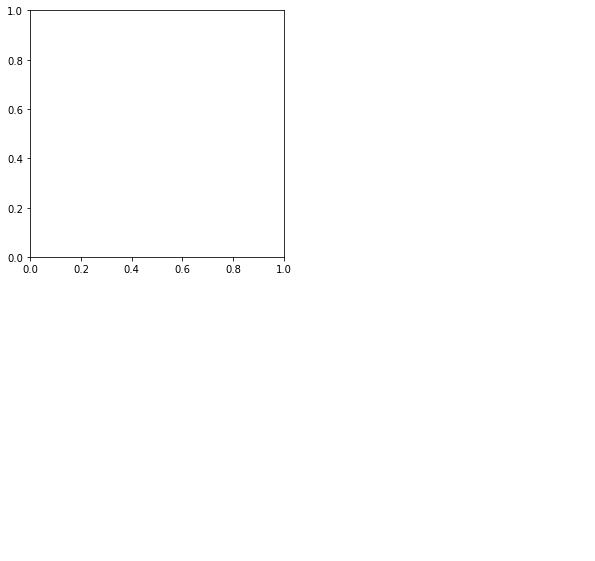

In [17]:
# なぞのtypeErrorにより先に進めない。。Dockerだからいけないのかな？
begin_training(train_dataset_dict, val_dataset_dict, model_dict, loss_dict, configs, color_map=new_cmap)

<div class="alert alert-block alert-warning"> 
  Common causes for errors during training, may include : <br>
    1. Not having <b>center images</b> for  <b>both</b> train and val directories  <br>
    2. <b>Mismatch</b> between type of center-images saved in <b>01-data.ipynb</b> and the type of center chosen in this notebook (see the <b><a href="#center"> center</a></b> parameter in the third code cell in this notebook)   <br>
    3. In case of resuming training from a previous checkpoint, please ensure that the model weights are read from the correct directory, using the <b><a href="#resume"> resume_path</a></b> parameter. Additionally, please ensure that the <b>save_dir</b> parameter for saving the model weights points to a relevant directory. 
</div>